In [14]:
# 1:54:49.48 to get a functioning encoding with just compartmental constraints.  Needs more time on probing the parameters
# 0 - 32:00.68: Setup basic encoding
# 32:00.68 - 48:00: Setup z3 solver and get results
# 48:00 - 1:27:15: Setup solution extraction
# 1:27:15 - 1:54:49.48: Setup solution plotting and explore 8 parameter bound settings to test
# 1:54:49.48 - 2:09:43.40: Cleanup code, comments, and improve plotting to interpolate
# 2:09:43.40 - 2:17:19.51: Add dreal and test

from pysmt.shortcuts import And, Or, Plus, Minus, Times, Div, REAL, LE, LT, GE, GT, Equals, Symbol, Real, Solver
from pysmt.fnode import  FNode
from typing import Dict
import pandas as pd
from decimal import Decimal
import numpy as np
from pysmt.logics import QF_NRA
from funman_dreal.solver import ensure_dreal_in_pysmt
import numpy as np
import itertools
import sir_model

ensure_dreal_in_pysmt()

def dataframe(assignment: Dict[Symbol, float], state_variables, parameters, max_step, step_size) -> pd.DataFrame:
    timepoints = list(range(0, max_time+step_size, step_size))
    timeseries = {sv: [None]*len(timepoints) for sv in state_variables}
    for k, v in assignment.items():
        sym = k.symbol_name()
        if "_" in sym:
            sv = sym.split("_")[0]
            t = sym.split("_")[1]
            value =Decimal(v.numerator) / Decimal(v.denominator)
            timeseries[sv][timepoints.index(int(t))] = value
        else:
            timeseries[sym] = [v]*len(timepoints)
    df = pd.DataFrame(timeseries, index=timepoints).astype(float)
    return df

def reindex_and_interpolate(df, new_index):
    df_reindexed = df.reindex(index = new_index)
    df_reindexed.interpolate(method = 'linear', inplace = True)
    return df_reindexed


def plot_results(values, max_step, step_size):
    timepoints = list(range(0, max_time+step_size, step_size))
    results: pd.DataFrame = dataframe(values, ["S", "I", "R"], ["beta", "gamma"], max_step, step_size)
    newindex = np.linspace(timepoints[0], timepoints[-1], timepoints[-1]+1)
    results = reindex_and_interpolate(results, newindex)
    print(f"beta = {results['beta'][0]}, gamma = {results['gamma'][0]}")
    print(results[["S", "I", "R"]])
    ax = results[["S", "I", "R"]].plot()
    ax.set_xlabel="Time"
    return ax, results

def run_solver(solver, formula):
    solver.add_assertion(formula)
    result = solver.solve()
    if result:
        model = solver.get_model()
        variables = formula.get_free_variables()
        values = {}
        for var in variables:
            try:
                values[var] = model.get_value(var).constant_value()
            except Exception as e:
                pass
    else:
        print("Unsat")
        values = None
    return values



In [2]:
# Generate model diagram

# from funman.api.run import Runner
# import json

# amr_model = "../../resources/amr/petrinet/amr-examples/sir.json"
# m = Runner().get_model(amr_model)
# g = m[0].to_dot()
# g.render("sir.pdf")

In [4]:
# The main encoding code
def encode(initial_values, parameter_bounds, infected_bounds, infected_timepoints, step_size=1, max_time=10, noise=1e-3, strict_upper_bound_parameters = False, use_compartmental=True):
    time_format = lambda t: f"{t:03d}"


    ################################################################################
    ################# Initial States ###############################################
    ################################################################################

    S_0 = Symbol(f"S_{time_format(0)}", REAL)
    I_0 = Symbol(f"I_{time_format(0)}", REAL)
    R_0 = Symbol(f"R_{time_format(0)}", REAL)

    S_0_value = initial_values["S"]
    I_0_value = initial_values["I"]
    R_0_value = initial_values["R"]


    population_size = S_0_value + I_0_value + R_0_value

    # SIR Model Initial State
    initial_state = And([
        Equals(S_0, Real(S_0_value)),
        Equals(I_0, Real(I_0_value)),
        Equals(R_0, Real(R_0_value))
    ])

    ################################################################################
    ################# Parameters     ###############################################
    ################################################################################


    # Parameters
    beta = Symbol("beta", REAL)
    gamma = Symbol("gamma", REAL)

    beta_bounds = parameter_bounds["beta"]
    gamma_bounds = parameter_bounds["gamma"]

    upper_op = LT if strict_upper_bound_parameters else LE

    parameters = And([
        And(LE(Real(beta_bounds[0]), beta), (upper_op(beta, Real(beta_bounds[1])) if beta_bounds[0] < beta_bounds[1] else LE(beta, Real(beta_bounds[1])))),
        And(LE(Real(gamma_bounds[0]), gamma), (upper_op(gamma, Real(gamma_bounds[1])) if gamma_bounds[0] < gamma_bounds[1] else LE(gamma, Real(gamma_bounds[1]))))
    ])


    timepoints = list(range(0, max_time+step_size, step_size))


    ################################################################################
    ################# Transitions ##################################################
    ################################################################################

    S_next = lambda t: Symbol(f"S_{time_format(t+step_size)}", REAL)
    S_now = lambda t: Symbol(f"S_{time_format(t)}", REAL)
    I_next = lambda t: Symbol(f"I_{time_format(t+step_size)}", REAL)
    I_now = lambda t: Symbol(f"I_{time_format(t)}", REAL)
    R_next = lambda t: Symbol(f"R_{time_format(t+step_size)}", REAL)
    R_now = lambda t: Symbol(f"R_{time_format(t)}", REAL)
    dt = Real(float(step_size))

    S_Trans = lambda t: Equals(S_next(t), 
                                    Minus(
                                        S_now(t), 
                                        Times([beta, S_now(t), I_now(t), dt])))

    I_Trans = lambda t: Equals(I_next(t), 
                                    Plus(
                                        I_now(t), 
                                        Times(
                                            Minus(
                                                Times([beta, S_now(t), I_now(t)]), 
                                                Times(gamma, I_now(t))), dt)))

    R_Trans = lambda t: Equals(R_next(t), 
                                    Plus(
                                        R_now(t), 
                                        Times(
                                            Times(gamma, I_now(t)), 
                                            dt)))

    Trans = lambda t: And(S_Trans(t), I_Trans(t), R_Trans(t))

    All_Trans = And([Trans(t) for t in timepoints[:-1]])


    ################################################################################
    ################# Constraints ##################################################
    ################################################################################

    compartmental_constraint = And([
        And( LE(Real(0.0), Plus(S_now(t), Real(noise))),
        LE(Real(0.0), Plus(I_now(t), Real(noise))),
        LE(Real(0.0), Plus(R_now(t), Real(noise))),
        LT(Plus([S_now(t), I_now(t), R_now(t)]), Plus(Real(population_size), Real(noise))), 
        GE(Plus([S_now(t), I_now(t), R_now(t)]), Minus(Real(population_size), Real(noise))))
    for t in timepoints]) if use_compartmental else TRUE()

    # 10m to add and check
    I_peak = infected_bounds
    I_peak_t = infected_timepoints
    
    peak_I = And([
        And(LE(Real(I_peak[0]), I_now(t)),
        LT(I_now(t), Real(I_peak[1])))
        for t in timepoints 
        if I_peak_t[0] <= t and t <= I_peak_t[1]
    ])


    ################################################################################
    ################# Combine Assertions ###########################################
    ################################################################################

    consistency = And([
        initial_state,
        parameters,
        All_Trans,
        compartmental_constraint,
        peak_I
        ])
    # consistency.serialize()
    return consistency

In [4]:
# # Solve encoding
# with Solver() as solver:
#     values = run_solver(solver)
    
# if values:
#     plot_results(values, timepoints)


beta = 0.15000000000000002, gamma = 0.025
             S         I         R
0.0   0.990000  0.010000  0.000000
1.0   0.988515  0.011235  0.000250
2.0   0.986849  0.012620  0.000531
3.0   0.984981  0.014173  0.000846
4.0   0.982887  0.015912  0.001201
...        ...       ...       ...
56.0  0.117645  0.538458  0.343897
57.0  0.108143  0.534498  0.357359
58.0  0.099473  0.529806  0.370721
59.0  0.091567  0.524466  0.383966
60.0  0.084364  0.518558  0.397078

[61 rows x 3 columns]


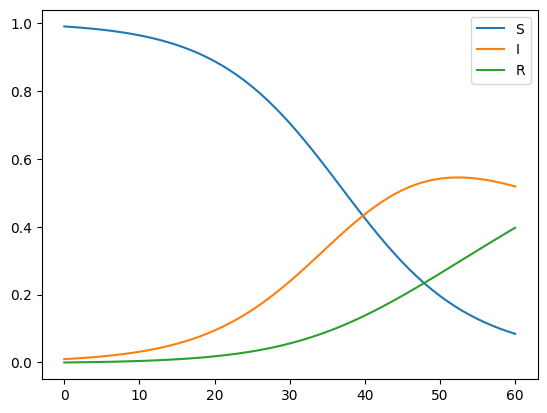

In [13]:
# Consistency using dreal

opts = {
        "dreal_precision": 1e-3,
        "dreal_log_level": "none",
        "dreal_mcts": True,
    }


# Configure these bounds (lower, upper) to configure the parameter space
parameter_bounds = {"beta": (0.15, 0.15), "gamma": (0.025, 0.025)}

# Set these values for the initial state
initial_values = {"S": 0.99, "I": 0.01, "R": 0.0}

# Infected constraint bounds
infected_bounds = (0.45, 0.55)
infected_timepoints = (45, 55)

# Timepoints
step_size = 1
max_time = 60

noise = 1e-3

values= None
with Solver(name="dreal",
            logic=QF_NRA,
            solver_options=opts
            ) as solver:
    values = run_solver(solver, encode(initial_values, parameter_bounds, infected_bounds, infected_timepoints, max_time=max_time, step_size=step_size, noise=noise, use_compartmental=True))
    pass
    
if values:
    ax, results = plot_results(values,  max_time, step_size)
    # f_pop = results.loc[float(max_time)][["S", "I", "R"]].sum()
    # print(f"Population at end: {f_pop}")
    # s = list(results.S.values)
    # print([s[i]-s[i-1] for i in range(1, len(s))])

beta = 0.17496597557264137, gamma = 0.031891187313515444
             S         I         R
0.0   0.990000  0.010000  0.000000
1.0   0.988268  0.011416  0.000317
2.0   0.986536  0.012831  0.000634
3.0   0.984328  0.014535  0.001041
4.0   0.982120  0.016239  0.001447
...        ...       ...       ...
56.0  0.064817  0.467489  0.467939
57.0  0.059510  0.456578  0.484273
58.0  0.054202  0.445667  0.500607
59.0  0.049969  0.436744  0.514973
60.0  0.045736  0.427821  0.529339

[61 rows x 3 columns]


ValueError: No axis named 50 for object type DataFrame

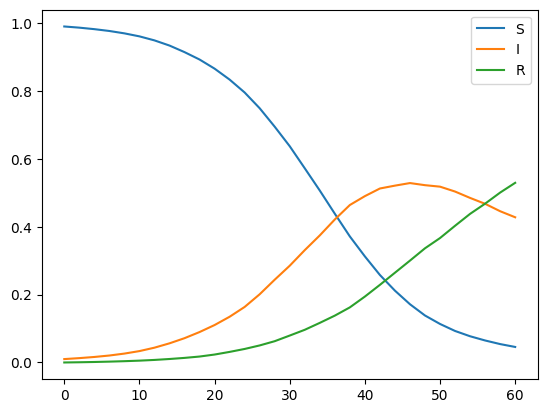

In [16]:
# Parameterization using dreal

opts = {
        "dreal_precision": 1e-2,
        "dreal_log_level": "info",
        "dreal_mcts": True,
    }


# Configure these bounds (lower, upper) to configure the parameter space
parameter_bounds = {"beta": (0.12, 0.22), "gamma": (0.015, 0.035)}

# Set these values for the initial state
initial_values = {"S": 0.99, "I": 0.01, "R": 0.0}

# Infected constraint bounds
infected_bounds = (0.45, 0.55)
infected_timepoints = (45, 55)

# Timepoints
step_size = 2
max_time = 60

noise = 1e-4

values= None
with Solver(name="dreal",
            logic=QF_NRA,
            solver_options=opts
            ) as solver:
    values = run_solver(solver, encode(initial_values, parameter_bounds, infected_bounds, infected_timepoints, max_time=max_time, step_size=step_size, noise=noise, use_compartmental=True))
    pass
    
if values:
    ax, results = plot_results(values,  max_time, step_size)
    
    # f_pop = results.loc[float(max_time)][["S", "I", "R"]].sum()
    # print(f"Population at end: {f_pop}")
    # s = list(results.S.values)
    # print([s[i]-s[i-1] for i in range(1, len(s))])

In [15]:
# Save SMTLIB file

# from funman.utils.smtlib_utils import smtlibscript_from_formula_list

# formula = encode(initial_values, parameter_bounds, infected_bounds, infected_timepoints, max_time=max_time, step_size=step_size, noise=noise, use_compartmental=True)
# filename = "dan.smt2"
# with open(filename, "w") as f:
#     print(f"Saving smtlib file: {filename}")
#     smtlibscript_from_formula_list(
#         [formula],
#         logic=QF_NRA,
#     ).serialize(f, daggify=False)


Saving smtlib file: dan.smt2


eval_point(): beta = 0.12, gamma = 0.015
Unsat
eval_point(): beta = 0.12, gamma = 0.02
Unsat
eval_point(): beta = 0.12, gamma = 0.025
Unsat
eval_point(): beta = 0.12, gamma = 0.030000000000000002
Unsat
eval_point(): beta = 0.12, gamma = 0.035
Unsat
eval_point(): beta = 0.145, gamma = 0.015
Unsat
eval_point(): beta = 0.145, gamma = 0.02
Unsat
eval_point(): beta = 0.145, gamma = 0.025
eval_point(): beta = 0.145, gamma = 0.030000000000000002
Unsat
eval_point(): beta = 0.145, gamma = 0.035
Unsat
eval_point(): beta = 0.16999999999999998, gamma = 0.015
Unsat
eval_point(): beta = 0.16999999999999998, gamma = 0.02
Unsat
eval_point(): beta = 0.16999999999999998, gamma = 0.025
Unsat
eval_point(): beta = 0.16999999999999998, gamma = 0.030000000000000002
eval_point(): beta = 0.16999999999999998, gamma = 0.035
Unsat
eval_point(): beta = 0.195, gamma = 0.015
Unsat
eval_point(): beta = 0.195, gamma = 0.02
Unsat
eval_point(): beta = 0.195, gamma = 0.025
Unsat
eval_point(): beta = 0.195, gamma = 0.0300

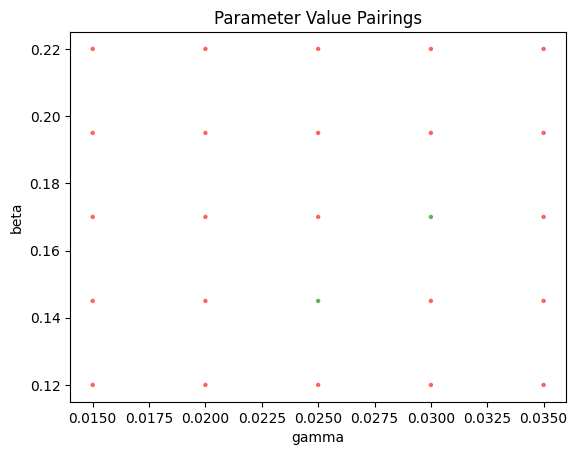

In [21]:
# Parameter Synthesis by points (similar to manual approach)

def eval_point(beta_val, gamma_val, plot=False):

    print(f"eval_point(): beta = {beta_val}, gamma = {gamma_val}")

    # parameters
    def beta(t): return np.piecewise(t, [t>=0], [beta_val])
    def gamma(t): return np.piecewise(t, [t>=0], [gamma_val])

    opts = {
            "dreal_precision": 1e-2,
            "dreal_log_level": "info",
            "dreal_mcts": True,
        }

    # Set these values for the initial state
    initial_values = {"S": 0.99, "I": 0.01, "R": 0.0}

    # Configure these bounds (lower, upper) to configure the parameter space
    parameter_bounds = {"beta": (beta_val, beta_val), "gamma": (gamma_val, gamma_val)}

    # Infected constraint bounds
    infected_bounds = (0.45, 0.55)
    infected_timepoints = (45, 55)

    # Timepoints
    step_size = 1
    max_time = 60

    noise = 1e-4

    values= None
    with Solver(name="dreal",
                logic=QF_NRA,
                solver_options=opts
                ) as solver:
        values = run_solver(solver, encode(initial_values, parameter_bounds, infected_bounds, infected_timepoints, max_time=max_time, step_size=step_size, noise=noise, use_compartmental=True))
        pass
        
    if values and plot:
        ax, results = plot_results(values,  max_time, step_size)

    param_assignments = {'beta': beta_val, 'gamma': gamma_val, 'assignment': "1" if values else "0"} # for "all", go through every option. for "any", only need one good parameter choice.
    return param_assignments



# set parameters
def ps(param_synth_method, parameter_search_bounds, num_dim_points=10, plot=False):
    parameters = list(parameter_search_bounds.keys())
    parameter_points = {p : np.linspace(parameter_search_bounds[p][0], parameter_search_bounds[p][1], num_dim_points) for p in parameters}
    points = itertools.product(*[parameter_points[p] for p in parameters])
    param_choices_true_false = []
    for point in points:
        point_values = {p: point[i] for i, p in enumerate(parameters)}

        param_assignments = eval_point(float(point_values["beta"]), float(point_values["gamma"]), plot=plot)
        param_choices_true_false.append(param_assignments)
        if param_synth_method == "any" and param_assignments['assignment'] == '1':
            return param_choices_true_false
    return param_choices_true_false


# Configure these bounds (lower, upper) to configure the parameter space
parameter_bounds = {"beta": (0.12, 0.22), "gamma": (0.015, 0.035)}
# parameter_bounds = {"beta": (0.17496597557264137, 0.17496597557264137), "gamma": (0.031891187313515444, 0.031891187313515444)}

param_choices = ps("all", parameter_bounds, num_dim_points=10)
print(param_choices)
sir_model.plot_two_params("gamma", "beta", param_choices)
